# Polarizability tensor of Water Molecule
With this notebook we would like to extract the polarizability terms for a water molecule in gas-phase,
with the aim of analysing the effects of these quantities in implicit solvent environment.
In a linear response regime, in a generic environment the electrostatic dipole of a H$_2$O molecule might be separated in two terms:
$$
\vec D = \vec D_0 + \mathbf P \cdot \vec E
$$
where $\vec D_0$ represents the molecular dipole in gas phase.
The polarizability tensor $\mathbf P$ represents the response of the molecular dipole to a external field described by the vector $\vec E$. 

To start the analysis let us consider one water molecule, and save its positions in the file 'H2O.xyz':

In [1]:
from BigDFT import Fragments as F, Logfiles as lf, Calculators as C
from futile import Yaml
#take as a molecule the first fragment of a Polaris snapshot
Polaris=Yaml.load('data/snap02000.yaml')
mp_dict=Polaris['dft']['external_potential']['values']
units=Polaris['dft']['external_potential']['units']
snap=F.System(mp_dict=mp_dict,units=units,nat_reference=3)
H2O=snap.fragments[0] 
H2O.line_up()
H2O.xyz()
H2O.xyz(filename='H2O.xyz')

3 atomic
# xyz dump 
O -2.86857851702e-07 1.76247905159e-15 0.735431116396
H 1.46392609098 2.55351295664e-15 -0.367715450117
H -1.46392580412 2.10942374679e-15 -0.36771566628


As a sidenote let us verify the O-H distances as well as the angle of the molecule:

In [2]:
import numpy as np
d0h1=H2O.rxyz(H2O.atoms[0])-H2O.rxyz(H2O.atoms[1])
d0h2=H2O.rxyz(H2O.atoms[0])-H2O.rxyz(H2O.atoms[2])
nrm1=np.sqrt(d0h1.dot(d0h1))
nrm2=np.sqrt(d0h2.dot(d0h2))
print nrm1*F.AU_to_A,nrm2*F.AU_to_A,np.arccos(d0h1.dot(d0h2)/nrm1/nrm2)*180.0/np.pi

0.969999695763 0.969999400908 106.000032564


Let us now set up a BigDFT input file for this molecule. We start from a calculation in cubic scaling approach:

In [3]:
input=Yaml.load(stream="""
logfile: No
dft:
  hgrids: 0.35
  ixc: LDA
#psppar.O: {Pseudopotential XC: 11} #to use PBE PSP for other functionals
#psppar.H: {Pseudopotential XC: 11}
#psolver:
#  environment:
#    cavity: water
#  import: water #this is given for the implicit cavity treatment
""")
input['posinp']={'positions': [ {H2O.element(at): H2O.rxyz(at).tolist()} for at in H2O.atoms]}

inputfile=open('input.yaml','w')
inputfile.write(str(input))
inputfile.close()

Let us now set up the calculator of the BigDFT, and run the DFT calculation for the molecule:

In [4]:
import os
os.environ['OMP_NUM_THREADS']='4'
bigdft=C.GIBinding()
bigdft.set(input)
out=bigdft.run()

The run performed successfully as we have a value for the energy.

In [5]:
out.eKS

-17.181324699852897

But... oops, we forget to create a logfile with this run. 
To do that let us put a name for this run and say to the input file the file name.

In [6]:
input['logfile']=True
input['radical']='GS' #which stands for Ground State... ;)
bigdft.update(input)

Ready, steady, go:

In [7]:
out=bigdft.run()

The logfile of the above run has been written in the file 'log-GS.yaml'. We may extract quantities like the DoS, the number of iterations, etc. To do that we may define an instance of the Logfile class.

In [8]:
H2OGS=lf.Logfile('log-GS.yaml')

- Atom types:
  - H
  - O
- Cell: Free BC
- Convergence criterion on forces: 0.0
- Symmetry group: disabled
- Energy: -17.18132470164937
- fermi_level: -0.2699589758132
- Number of Atoms: 3
- Convergence criterion on Wfn. Residue: 0.0001
- No. of KS orbitals per k-point:
  - 4
  - 0



/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


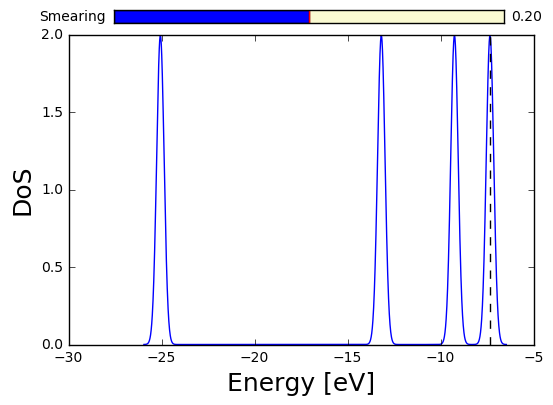

In [9]:
print H2OGS
H2OGS.get_dos().plot()

Let us extract from this logfile the dipole moment.

In [10]:
print H2OGS.log['Electric Dipole Moment (AU)']
#norm in Debye
print H2OGS.log['Electric Dipole Moment (Debye)']['norm(P)']

{'norm(P)': 0.7211601, 'P vector': [-7.7827e-05, -0.00045548, -0.72116]}
1.833006


We can now see that the GS dipole is oriented along the z-axis.
Let us now add a small electric field to the system to see how the dipole vector is modified:

In [11]:
input['dft']['elecfield']=[0.0,1.e-3,0.0]
input['radical']='Ey'
input['dft']['gnrm_cv']=1.e-5 # let us lower gnrm_cv to reduce hysteresis effects between restarts
bigdft.set(input)

In [12]:
out=bigdft.run()

The energy changed veery little:

In [13]:
out.eKS

-17.181329371140446

But the electric dipole changed more than a little:

In [14]:
H2OEy=lf.Logfile('log-Ey.yaml')
H2OEy.log['Electric Dipole Moment (AU)']

{'P vector': [-7.0685e-05, 0.0097952, -0.72115], 'norm(P)': 0.7212177}

Let us now do all the other axis

In [15]:
input['dft']['elecfield']=[1.e-3,0.0,0.0]
input['radical']='Ex'
bigdft.set(input)
out=bigdft.run()
H2OEx=lf.Logfile('log-Ex.yaml')
print H2OEx.log['Electric Dipole Moment (AU)']
input['dft']['elecfield']=[0.0,0.0,1.e-3]
input['radical']='Ez'
bigdft.set(input)
out=bigdft.run()
H2OEz=lf.Logfile('log-Ez.yaml')
print H2OEz.log['Electric Dipole Moment (AU)']

{'norm(P)': 0.7212322, 'P vector': [0.010738, -0.00046043, -0.72115]}
{'norm(P)': 0.7106412, 'P vector': [-7.045e-05, -0.00045824, -0.71064]}


Now we have all the components of our linear system. We extract the variations of the dipole:

In [16]:
def dipole(log):
    import numpy
    return numpy.array(log.log['Electric Dipole Moment (AU)']['P vector'])
D0=dipole(H2OGS)
D=np.mat(np.zeros(9)).reshape(3,3)
D[0]=dipole(H2OEx)-D0
D[1]=dipole(H2OEy)-D0
D[2]=dipole(H2OEz)-D0
print D/1.e-3 #which is the norm of the Electric field applied here

[[  1.08158270e+01  -4.95000000e-03   1.00000000e-02]
 [  7.14200000e-03   1.02506800e+01   1.00000000e-02]
 [  7.37700000e-03  -2.76000000e-03   1.05200000e+01]]


Here we see that the polarizability tensor is almost diagonal as the induced dipole is always proportional to the provided electric field.

Let us free the BigDFT objects as we are well-educated guys.

In [17]:
out = None
bigdft = None